In [1]:
%pip install opencv-python
import numpy as np
import cv2
import os
from pathlib import Path

# Hàm hỗ trợ chuyển mảng Numpy thành chuỗi để lưu vào file
def nparray_to_str(X):
    return '\n'.join([' '.join(str(X[i])[1:-1].split()) for i in range(len(X))])

# Hàm tạo points.txt và clusters.txt
def generate_data(src_img, dst_folder, k):
    points_path = os.path.join(dst_folder, 'points.txt')
    clusters_path = os.path.join(dst_folder, 'clusters.txt')

    Path(dst_folder).mkdir(parents=True, exist_ok=True)

    # Load ảnh và tạo points.txt
    img = cv2.imread(src_img).reshape((-1, 3)).astype(np.float32)
    with open(points_path, 'w') as f:
        f.write(nparray_to_str(img))
    print(f'Points saved in: {points_path}')

    # Tạo clusters.txt
    s = np.random.uniform(low=img.min(), high=img.max(), size=(k, 3))
    tmp_labels = np.arange(1, k + 1).reshape((k, 1))
    clusters = np.hstack((tmp_labels, s))

    with open(clusters_path, 'w') as f:
        f.write(nparray_to_str(clusters))
    print(f'Centroids saved in: {clusters_path}')

# Hàm load dữ liệu từ file
def load_data(file_path, has_id=False):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            points = list(map(float, line.strip().split()[1:] if has_id else line.strip().split()))
            data.append(points)
    return np.array(data)



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Đường dẫn ảnh và thư mục đầu ra
src_img = "F:/sinhviennam3/kmeans_mapreduce-master/src_new/image1.jpg"
dst_folder = "F:/sinhviennam3/kmeans_mapreduce-master/src_new"
k = 10  # Số lượng cụm

# Tạo dữ liệu
generate_data(src_img, dst_folder, k)


Points saved in: F:/sinhviennam3/kmeans_mapreduce-master/src_new\points.txt
Centroids saved in: F:/sinhviennam3/kmeans_mapreduce-master/src_new\clusters.txt


In [3]:
# Load points.txt và clusters.txt
points = load_data(os.path.join(dst_folder, 'points.txt'), has_id=False)
clusters = load_data(os.path.join(dst_folder, 'clusters.txt'), has_id=True)

# Kiểm tra dữ liệu
print(f"Points shape: {points.shape}")
print(f"Clusters shape: {clusters.shape}")


Points shape: (500000, 3)
Clusters shape: (10, 3)


In [4]:
# Artificial Bee Colony (ABC)
class ArtificialBeeColony:
    def __init__(self, n_bees, n_dimensions, bounds, fitness_function, max_iterations, delta):
        self.n_bees = n_bees
        self.n_dimensions = n_dimensions
        self.bounds = bounds
        self.fitness_function = fitness_function
        self.max_iterations = max_iterations
        self.delta = delta

        self.positions = np.array([
            [np.random.uniform(bounds[j][0], bounds[j][1]) for j in range(n_dimensions)]
            for _ in range(n_bees)
        ])
        self.fitness = np.array([self.fitness_function(pos) for pos in self.positions])
        self.trial_counters = np.zeros(n_bees)

    def optimize(self):
        best_solution = None
        best_fitness = float('inf')

        for iteration in range(self.max_iterations):
            for i in range(self.n_bees):
                k = np.random.choice([x for x in range(self.n_bees) if x != i])
                phi = np.random.uniform(-1, 1)
                new_position = self.positions[i] + phi * (self.positions[i] - self.positions[k])
                new_position = np.clip(new_position, *zip(*self.bounds))
                new_fitness = self.fitness_function(new_position)

                if new_fitness < self.fitness[i]:
                    self.positions[i] = new_position
                    self.fitness[i] = new_fitness
                    self.trial_counters[i] = 0
                else:
                    self.trial_counters[i] += 1

            for i in range(self.n_bees):
                if self.trial_counters[i] > self.delta:
                    new_position = np.array([
                        np.random.uniform(self.bounds[j][0], self.bounds[j][1])
                        for j in range(self.n_dimensions)
                    ])
                    self.positions[i] = new_position
                    self.fitness[i] = self.fitness_function(new_position)
                    self.trial_counters[i] = 0


            current_best = np.argmin(self.fitness)
            if self.fitness[current_best] < best_fitness:
                best_solution = self.positions[current_best]
                best_fitness = self.fitness[current_best]

        return best_solution, best_fitness

# Tối ưu centroids với ABC
bounds = [(np.min(points[:, j]), np.max(points[:, j])) for j in range(points.shape[1])]
def fitness_function(position): return np.sum(position ** 2)
abc = ArtificialBeeColony(n_bees=20, n_dimensions=clusters.shape[1], bounds=bounds, fitness_function=fitness_function, max_iterations=50, delta=10)
best_solution, _ = abc.optimize()


In [5]:
class KMeans:
    def __init__(self, n_clusters, max_iterations=300):
        self.n_clusters = n_clusters
        self.max_iterations = max_iterations
        self.centroids = None

    def fit(self, X):
        random_indices = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[random_indices]

        for _ in range(self.max_iterations):
            clusters = self._assign_clusters(X)
            new_centroids = np.array([np.mean(X[clusters == k], axis=0) for k in range(self.n_clusters)])
            if np.all(new_centroids == self.centroids):
                break
            self.centroids = new_centroids

    def predict(self, X):
        return self._assign_clusters(X)

    def _assign_clusters(self, X):
        distances = np.array([[np.linalg.norm(x - centroid) for centroid in self.centroids] for x in X])
        return np.argmin(distances, axis=1)

# Thực hiện K-Means
kmeans = KMeans(n_clusters=clusters.shape[0])
kmeans.centroids = clusters[:, 1:]  # Use centroids optimized by ABC
kmeans.fit(points)


In [6]:
# def visualize_results(centroids, src_img, dst_img):
#     img = cv2.imread(src_img)
#     shape = img.shape
#     img = img.reshape((-1, 3))
#     new_image = np.zeros_like(img)

#     for i in range(img.shape[0]):
#         ind = np.linalg.norm(centroids - img[i], axis=-1).argmin()
#         new_image[i] = centroids[ind].astype(np.uint8)

#     cv2.imwrite(dst_img, new_image.reshape(shape))
#     print(f"Result saved in: {dst_img}")

# # Trực quan hóa kết quả
# dst_img = os.path.join(dst_folder, "image1_result.jpg")
# visualize_results(kmeans.centroids, src_img, dst_img)


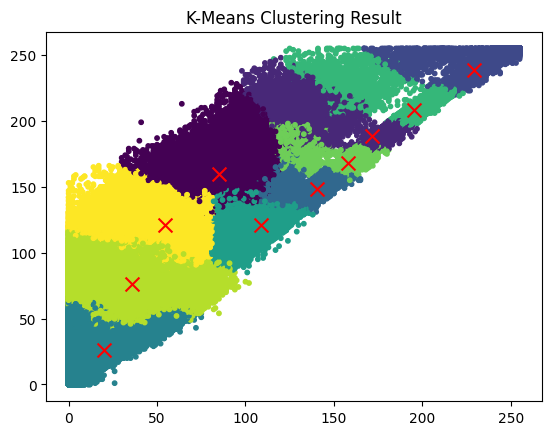

In [7]:
import matplotlib.pyplot as plt

labels = kmeans.predict(points)
plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='viridis', s=10)
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], color='red', marker='x', s=100)
plt.title("K-Means Clustering Result")
plt.show()


In [8]:
def calculate_sse(points, centroids, labels):
    sse = 0
    for i in range(len(centroids)):
        cluster_points = points[labels == i]
        sse += np.sum((cluster_points - centroids[i]) ** 2)
    return sse

labels = kmeans.predict(points)
sse = calculate_sse(points, kmeans.centroids, labels)
print("SSE:", sse)


SSE: 245498070.30738327


In [9]:
kmeans_traditional = KMeans(n_clusters=clusters.shape[0])
kmeans_traditional.fit(points)

In [ ]:
labels_traditional = kmeans_traditional.predict(points)
sse = calculate_sse(points, kmeans_traditional.centroids, labels_traditional)
print("SSE Traditional: ", sse)

SSE Traditional: 826437817.263663
